# Project: Mobile Manipulator Planning
**Course:** Roboterprogrammierung (Winter 25/26)  
**Institution:** Hochschule Karlsruhe - University of Applied Sciences (HKA)  

## 🎯 Objective
This notebook implements and evaluates a **Collision Checker** for a planar mobile robot consisting of a movable base and a 2-DOF rotatory arm. The goal is to benchmark path planning algorithms (LazyPRM, VisibilityPRM, etc.) in various environments while handling self-collisions and obstacle avoidance.

## ⚙️ Key Features
* **Mobile Base:** Free-form shape definition (2D).
* **Manipulator:** Configurable arm segments (Length, Thickness, Joint Limits).
* **Collision Detection:** Custom implementation handling Base-Obstacle, Arm-Obstacle, and Self-Collision (Arm-Base).

## Imports & Autoreload


In [1]:
# --- Auto-reload modules when source code changes ---
# This is crucial so you don't have to restart the kernel when editing src/ files
%load_ext autoreload
%autoreload 2

# --- Standard Imports ---
import copy

import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Needed for the custom legend
import matplotlib.ticker as ticker

import networkx as nx

import numpy as np

import os

import pandas as pd

import sys

from ipywidgets import interact, FloatSlider, Dropdown, Layout, Checkbox, Button, VBox, HBox, Output
from IPython.display import HTML, display, clear_output


# --- Add 'src' directory to path to import modules ---
# Assuming this notebook is in the 'notebooks/' folder and source is in 'src/'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
# IMPORTANT: To ensure that it finds its dependencies (IPTestSuite),
# we explicitly add the src folder to the path.
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
# IMPORTANT: To ensure that IPLazyPRM finds its dependencies (IPPerfMonitor),
# we explicitly add the src/planners folder to the path.
planners_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src', 'planners'))
if planners_path not in sys.path:
    sys.path.append(planners_path)

print(f"Project Root added to path: {project_root}")
print(f"Planner Root added to path: {planners_path}")

# --- Import Test Suite ---
from IPTestSuite import * #benchList, START, GOAL, LIMITS, ROBOT_BASE_SHAPE, ROBOT_ARM_CONFIG, ARM_OFFSET

# --- Import Animator ---
from IPAnimator import IPAnimator

# --- Import Performance Monitor ---
from IPPerfMonitor import IPPerfMonitor

# --- Import Result Collection ---
from IPResultCollection import ResultCollection

# --- Import Batch Evaluator
from IPBatchEvaluator import BatchEvaluator

# --- Import Planner Runner ---
from IPMultiGoalPlannerRunner import MultiGoalPlannerRunner

# --- Import Visualisator ---
from IPBenchmarkPlotter import BenchmarkPlotter
from IPBatchPlotter import BatchPlotter
from IPSingleRunPlotter import SingleRunPlotter

# --- Import Planners ---
# Visibility PRM
from IPVisibilityPRM import VisPRM as VisPRM
from IPVisibilityPRM_multiGoal import VisPRM as VisPRM_multiGoal
from IPVISVisibilityPRM import visibilityPRMVisualize
# Lazy PRM
from IPLazyPRM import LazyPRM as LazyPRM
from IPLazyPRM_multiGoal import LazyPRM as LazyPRM_multiGoal
from IPVISLazyPRM import lazyPRMVisualize

savePlots = False
folderPath2save = "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/runs/20260119_SelfCheck"


Project Root added to path: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator
Planner Root added to path: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners
TestSuite geladen. Benchmarks für Pick & Place konfiguriert.


## Creating Planner Factory

In [2]:
plannerFactory = dict()

# --- Visibility PRM ---
# Strategie: VisPRM verwirft Knoten, die "sichtbar" sind. In 5D ist das Risiko hoch, 
# dass wir wichtige Verbindungsknoten zu früh verwerfen oder gar nicht finden.
# Daher: Sehr hohes 'ntry', damit er oft genug würfelt, um die "Guards" in den engen Passagen zu finden.
visbilityConfig = dict()
visbilityConfig["ntry"] = 500  # Empfehlung: 400 - 800 für 5D
plannerFactory["visibilityPRM"] = [VisPRM, visbilityConfig, visibilityPRMVisualize]

# --- Lazy PRM ---
# Strategie: "Shoot first, ask questions later". 
# Wir fluten den Raum mit Knoten.
lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 500  # Startet mit vielen Knoten für gute Abdeckung
lazyConfig["updateRoadmapSize"]  = 200  # Wenn kein Pfad, leg ordentlich nach
lazyConfig["kNearest"] = 12             # 5D braucht mehr Nachbarn für stabile Pfade (Standard 2D ist oft 5-6)
lazyConfig["maxIterations"] = 15        # Gib ihm Zeit, den Graphen zu vergrößern, falls es eng wird
plannerFactory["lazyPRM"] = [LazyPRM, lazyConfig, lazyPRMVisualize]

print("Planner initialization successfull. Following Planners loaded:")
plannerNames = []
for planner in plannerFactory:
    plannerNames.append(planner)
    print(f"    {planner}")

print("Benchmarks initialization successfull. Following Benchmarks loaded:")
benchNames = []
for benchmark in benchList:
    benchNames.append(benchmark.name)
    print(f"    {benchmark.name}")

Planner initialization successfull. Following Planners loaded:
    visibilityPRM
    lazyPRM
Benchmarks initialization successfull. Following Benchmarks loaded:
    Empty World
    The Wall
    Narrow Passage
    Forest
    Shelf Reach


## Interactive Visualization

In [ ]:
# --- Setup ---
# Namen für das Dropdown-Menü extrahieren
bench_names = [b.name for b in benchList]

def interact_bench_suite(bench_name, x, y, theta, q1, q2, attach_obj):
    """
    Interaktive Steuerung des Roboters in einer ausgewählten Benchmark-Umgebung.
    """
    plt.close('all')

    # 1. Den passenden Benchmark und CollisionChecker auswählen
    # Wir suchen das Benchmark-Objekt anhand des Namens
    current_bench = next(b for b in benchList if b.name == bench_name)
    cc = current_bench.collisionChecker

    # --- NEU: Objekt anhängen/abhängen basierend auf Checkbox ---
    # Wir greifen auf das globale PICK_OBJECT zu (oder current_bench.objectShape)
    if attach_obj:
        # Falls PICK_OBJECT nicht global verfügbar ist, nutze current_bench.objectShape
        obj_shape = cc.get_object_shape()
        cc.attach_object(obj_shape)
    else:
        cc.detach_object()
    # -----------------------------------------------------------

    # 3. Konfiguration erstellen (Numpy Array!)
    config = np.array([x, y, theta, q1, q2], dtype=float)

    # 4. Kollision prüfen
    try:
        if hasattr(cc, 'pointInCollision'):
            is_collision = cc.pointInCollision(config)
    except Exception as e:
        print(f"Fehler Collision Check: {e}")
        is_collision = True

    # 5. Zeichnen
    try:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # --- A. Hindernisse und aktueller Roboter ---
        cc.drawObstacles(ax)
        cc.drawRobot(config, ax, alpha=1)
        
        # --- B. Start und Ziel des Benchmarks einblenden (Hilfreich!) ---
        # Startkonfiguration (Grün gestrichelt)
        start_conf = np.array(current_bench.startList[0])
        # print(start_conf)
        # print(start_conf)
        geo_start = cc.get_robot_geometry(start_conf)
        ax.plot(*geo_start['base'].exterior.xy, color='green', linestyle='--', alpha=0.5, label='Start Base')
        
        # Zielkonfiguration (Rot gestrichelt)
        for goals in current_bench.goalList:
            # goalList Einträge können Tupel (Pos, Action) oder Listen (Pos) sein
            # Wir extrahieren sicherheitshalber nur die Koordinate
            goal_raw = goals[0] # if isinstance(goals, (tuple, list)) and len(goals) == 2 and isinstance(goals[1], str) else goals
            
            goal_conf = np.array(goal_raw)
            # print(goal_conf)
            
            # Farbe bestimmen (letztes Ziel rot, Zwischenziele lila)
            # Hinweis: Der Vergleich von Arrays benötigt .all()
            last_goal_raw = current_bench.goalList[-1]
            last_goal_coords = last_goal_raw[0] if isinstance(last_goal_raw, (tuple, list)) and len(last_goal_raw) == 2 and isinstance(last_goal_raw[1], str) else last_goal_raw
            
            if np.allclose(goal_conf, last_goal_coords):
                goal_color = 'red'
            else:
                goal_color = 'purple'
                
            geo_goal = cc.get_robot_geometry(goal_conf)
            ax.plot(*geo_goal['base'].exterior.xy, color=goal_color, linestyle='--', alpha=0.5, label='Goal Base')
        
        # Arme für Start/Ziel auch andeuten (optional, hier nur Basis der Übersicht halber)

        # --- C. Plot Settings ---
        ax.set_xlim(LIMITS[0]) # Setzt min_x und max_x
        ax.set_ylim(LIMITS[1]) # Setzt min_y und max_y
        ax.set_aspect('equal') # Verhindert Verzerrung (Kreise bleiben rund)

        ax.axis('on') 
        
        # Major Ticks auf 1.0
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
        
        # Minor Ticks auf 0.5
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        
        # Gitter zeichnen
        ax.grid(which='major', alpha=0.5, color='gray', linestyle='-')
        ax.grid(which='minor', alpha=0.2, color='gray', linestyle='--')
        
        # Labels anzeigen
        ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

        ax.legend(loc='upper left')

        # Titel & Status
        status_color = 'red' if is_collision else 'green'
        status_text = "COLLISION!" if is_collision else "FREE"
        attach_text = " [HOLDING OBJECT]" if attach_obj else ""
        
        ax.set_title(f"Scenario: {bench_name}{attach_text} \nStatus: {status_text} | Self check: {SELF_CHECK}", 
                     color=status_color, fontweight='bold', fontsize=14)
        
        plt.show()
        
    except Exception as e:
        print(f"Fehler beim Zeichnen: {e}")
        import traceback
        traceback.print_exc()
        

# --- Widgets erstellen ---
point_to_show = START[0]#GOAL[1][0]
interact(interact_bench_suite, 
         bench_name=Dropdown(options=bench_names, description='Scenario:'),
         attach_obj=Checkbox(value=False, description='Attach Object'),
         x=FloatSlider(min=LIMITS[0][0], max=LIMITS[0][1], step=0.1, value=point_to_show[0]),
         y=FloatSlider(min=LIMITS[1][0], max=LIMITS[1][1], step=0.1, value=point_to_show[1]),
         theta=FloatSlider(min=LIMITS[2][0], max=LIMITS[2][1], step=0.01, value=point_to_show[2], description='Base Theta'),
         # Die Limits für die Gelenke holen wir direkt aus der zentralen Config
         q1=FloatSlider(min=LIMITS[3][0], max=LIMITS[3][1], step=0.01, value=point_to_show[3], description='Joint 1'),
         q2=FloatSlider(min=LIMITS[4][0], max=LIMITS[4][1], step=0.01, value=point_to_show[4], description='Joint 2')
        );

interactive(children=(Dropdown(description='Scenario:', options=('Empty World', 'The Wall', 'Narrow Passage', …

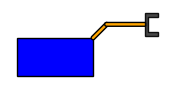

In [4]:
cc = benchList[0].collisionChecker

fig, ax = plt.subplots(figsize=(2, 2))

# --- A. Hindernisse und aktueller Roboter ---
cc.drawObstacles(ax)
cc.drawRobot(START[0], ax, alpha=1)


# Arme für Start/Ziel auch andeuten (optional, hier nur Basis der Übersicht halber)

# --- C. Plot Settings ---
# ax.set_xlim([-4.5,0]) # Setzt min_x und max_x
# ax.set_ylim(-5,-2.5) # Setzt min_y und max_y
ax.set_aspect('equal') # Verhindert Verzerrung (Kreise bleiben rund)

ax.axis('off') 

plt.show()

## Planning

In [5]:
resultList = list()
plotList = []

for key, producer in list(plannerFactory.items()):
    print("="*50)
    print(f"{key}:")
    for benchmark in benchList:
        print(f"    Running Benchmark {benchmark.name}")
        
        # Planner instanziieren
        planner = producer[0](benchmark.collisionChecker)
        config = producer[1]
        
        IPPerfMonitor.clearData()
        
        try:
            # --- Hier passiert jetzt die Magie in einer Zeile ---
            full_path, action_events, status = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
            
            # Ergebnis speichern
            resultList.append(ResultCollection(
                plannerFactoryName=key,
                planner=planner, # Der Planner wurde in run_benchmark manipuliert (Graph, Edges)
                benchmark=benchmark,
                solution=full_path, 
                actions=action_events,
                status=status,
                perfDataFrame=IPPerfMonitor.dataFrame()
                )
            )

            if status['success']:
                # plotList.append(1) # Grün in der Visualisierung
                pass
            else:
                # Wir plotten es trotzdem (damit man sieht wie weit er kam), markieren es aber
                print(f"        PARTIAL PATH: {status['fail_reason']}")
            plotList.append(1) # 1 = Plotten, aber wir wissen es ist unvollständig
            
        except Exception as e:
            plotList.append(0)
            print("        PLANNING ERROR:", e)
            # Optional: Traceback für Details
            # import traceback
            # traceback.print_exc()
            pass

print("="*50)

visibilityPRM:
    Running Benchmark Empty World
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running Benchmark The Wall
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running 

## Visualization

dict_values(['red', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightgreen', 'lightgreen', 'red', 'red', 'lightblue', 'red', 'lightblue', 'lightgreen', 'lightgreen', 'red', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightgreen', 'lightgreen'])


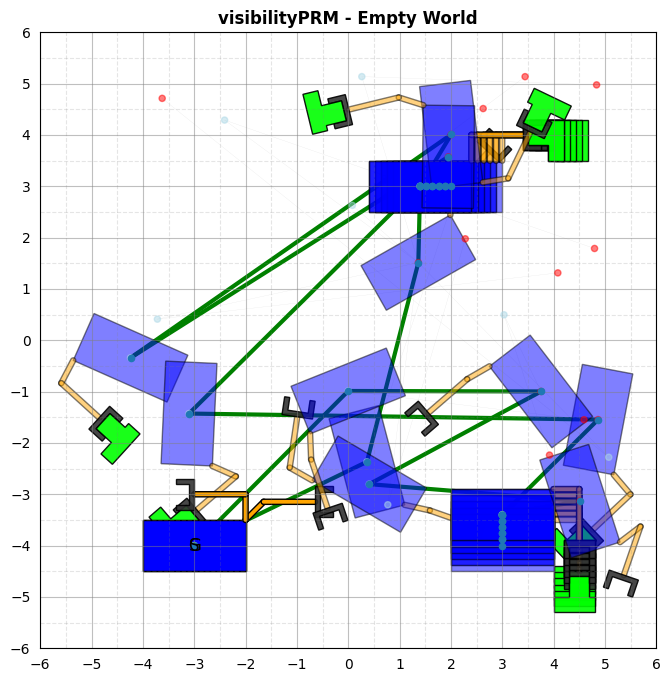

dict_values(['red', 'red', 'red', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightgreen', 'lightgreen', 'red', 'red', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'ligh

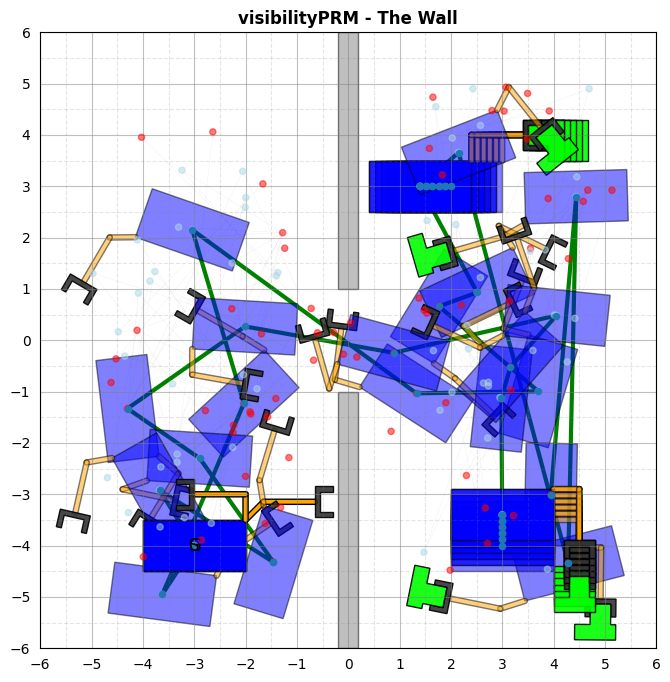

dict_values([])


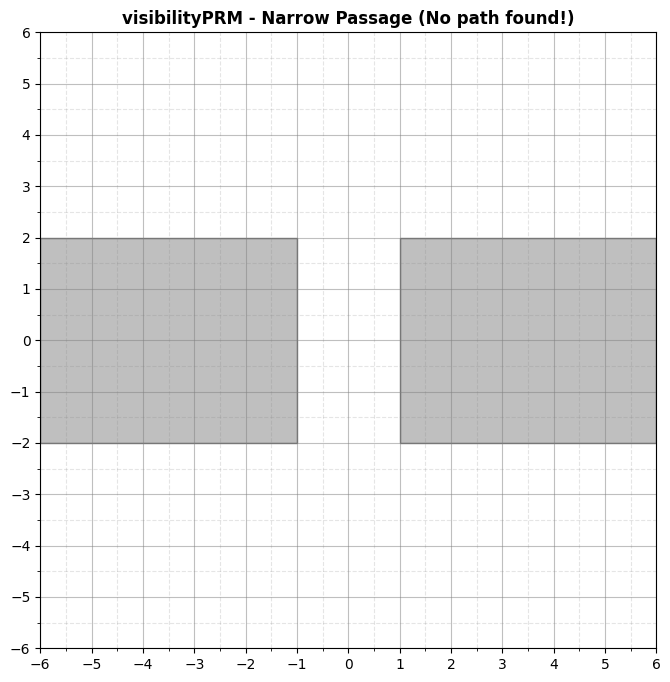

dict_values(['red', 'red', 'red', 'red', 'red', 'red', 'red', 'lightblue', 'lightblue', 'lightblue', 'red', 'lightblue', 'lightblue', 'lightblue', 'red', 'red', 'red', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'red', 'lightblue', 'red', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightgreen', 'lightgreen', 'red', 'red', 'red', 'red', 'red', 're

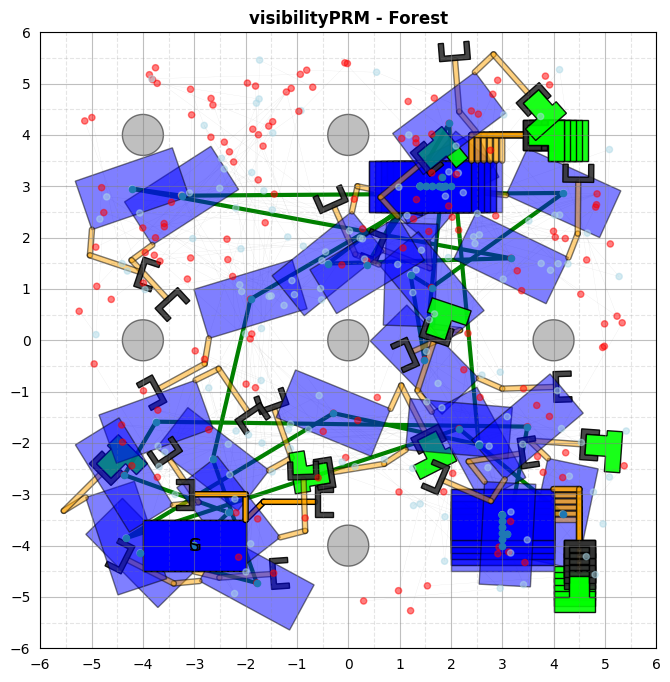

dict_values(['red', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'red', 'lightblue', 'red', 'lightblue', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'red', 'lightblue', 'lightgreen', 'lightgreen'])


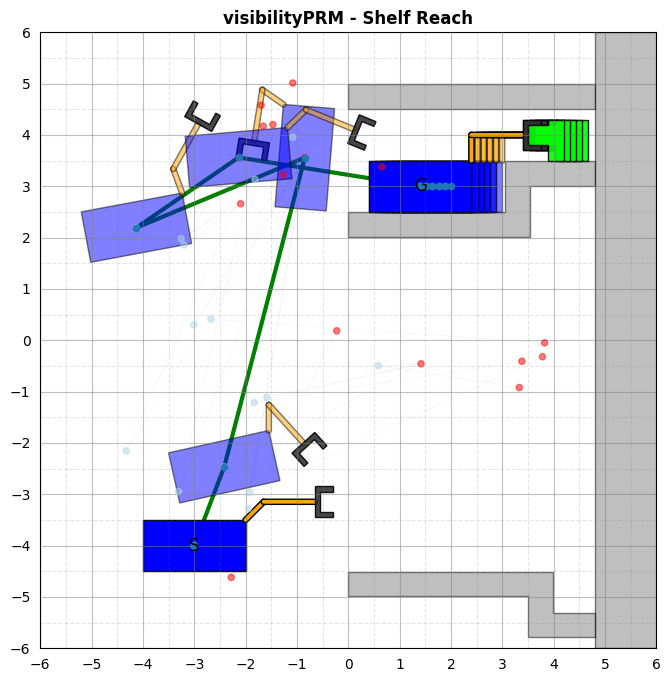

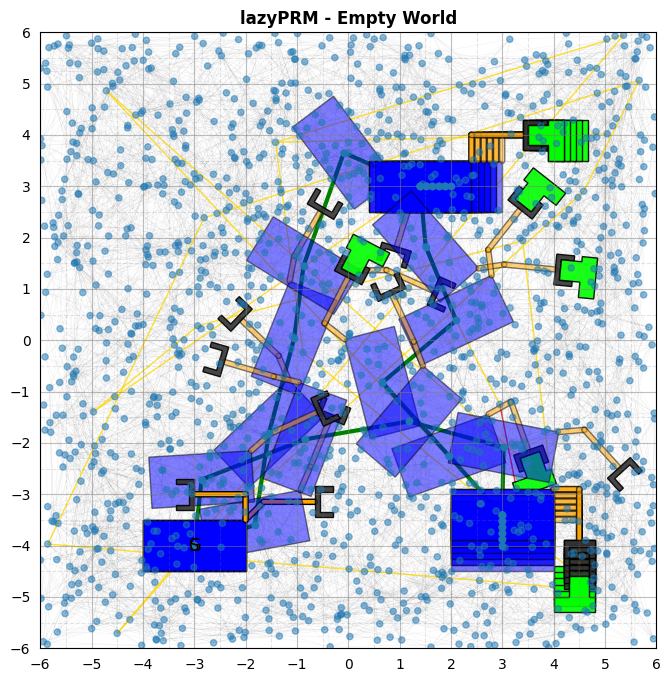

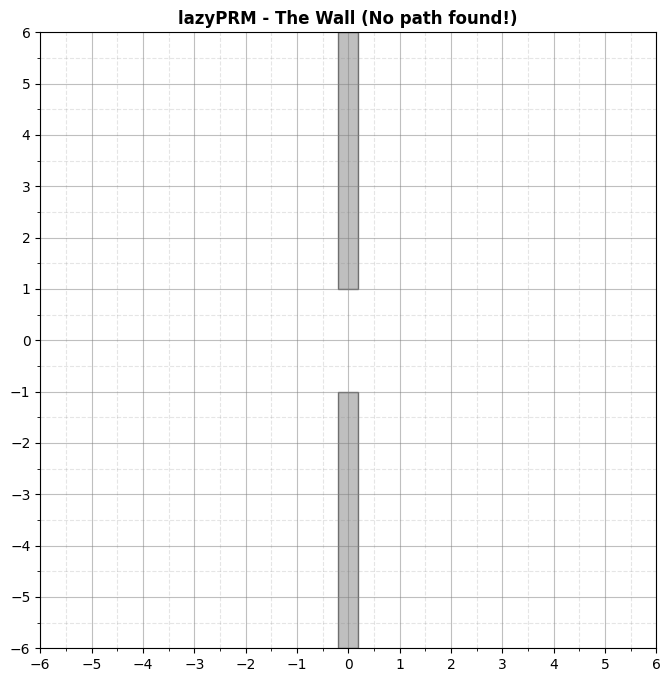

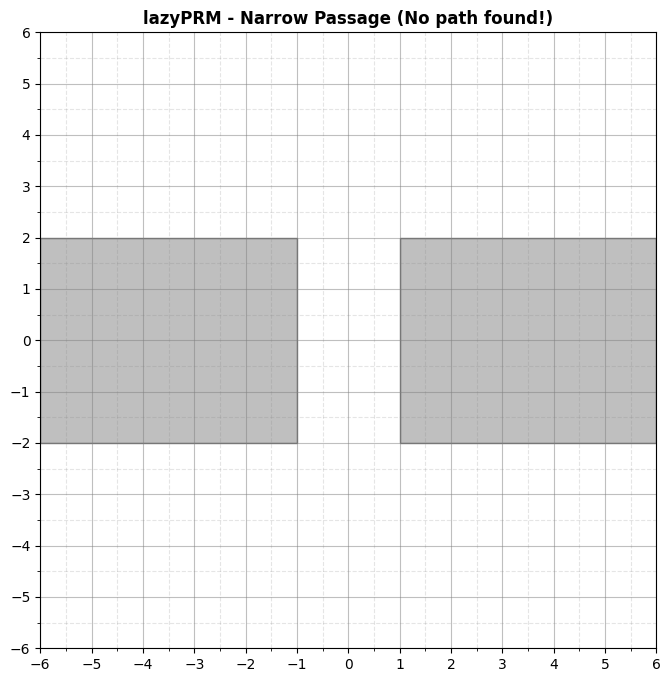

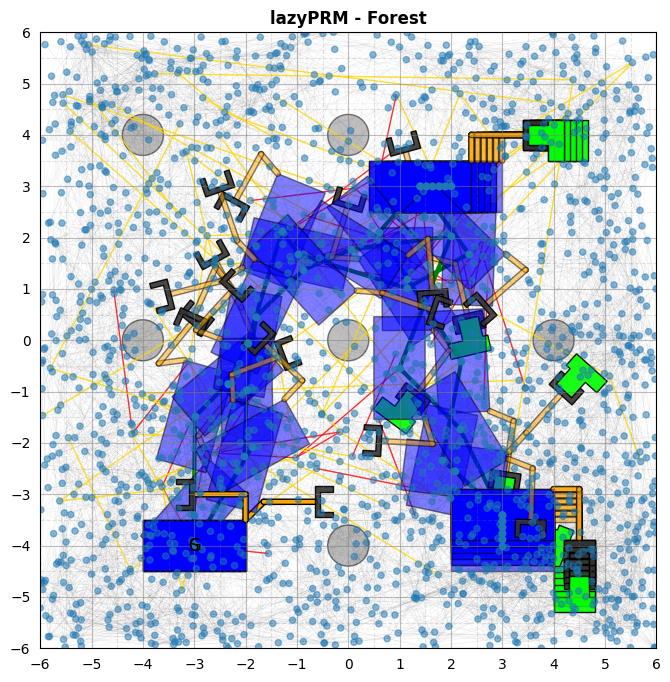

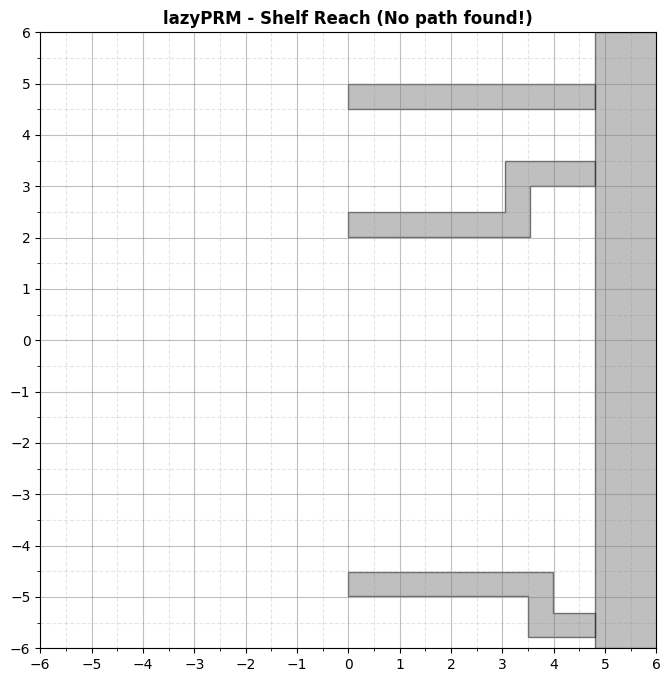

In [37]:
# Ausführen
# plannerNames und benchNames hast du ja oben im Notebook definiert
SingleRunPlotter.visualize_and_save(
    resultList, 
    plotList, 
    plannerNames, 
    benchNames, 
    plannerFactory, 
    save_plots=savePlots,       # Auf True setzen zum Speichern
    output_dir=folderPath2save # Ordnername
)

## Visualization with Animation

In [7]:
# Setup Limits (falls nicht global vorhanden)
try:
    anim_limits = LIMITS
except NameError:
    anim_limits = (-10, 25)

# UI erstellen und anzeigen
ui = IPAnimator.create_interactive_viewer(plannerFactory, resultList, limits=anim_limits)
display(ui)

## Benchmark

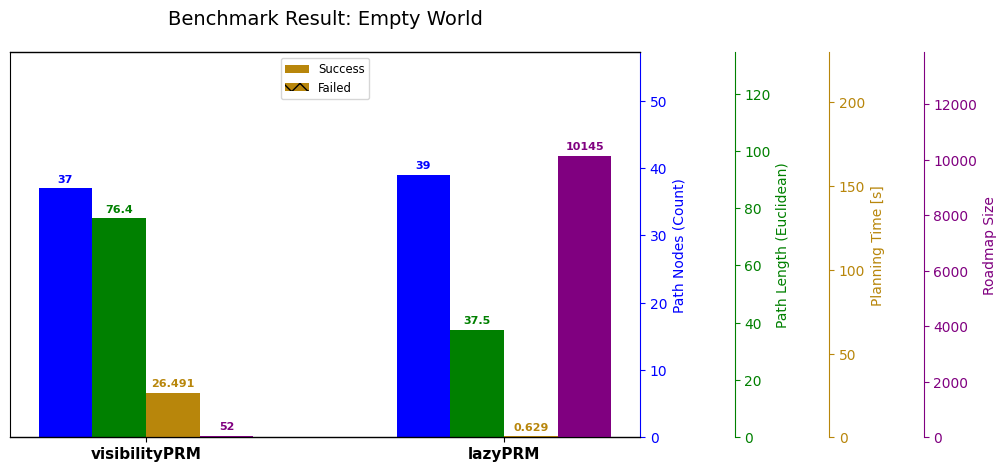

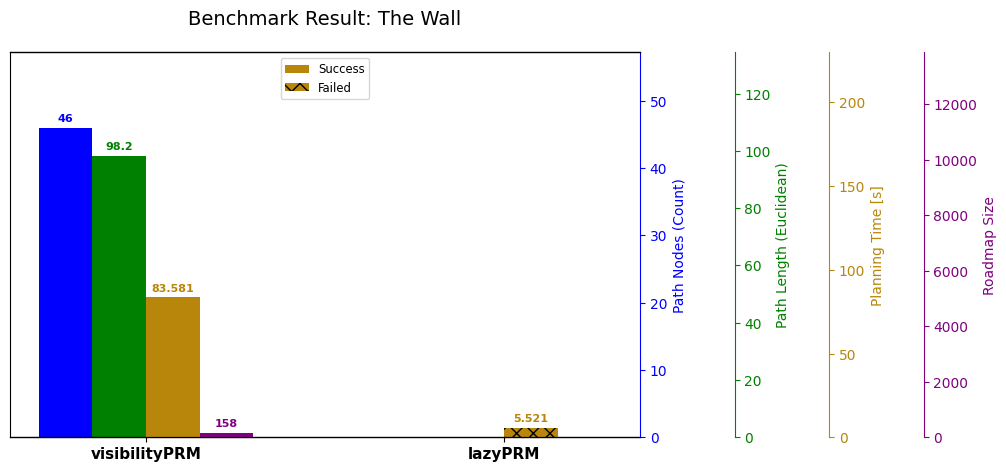

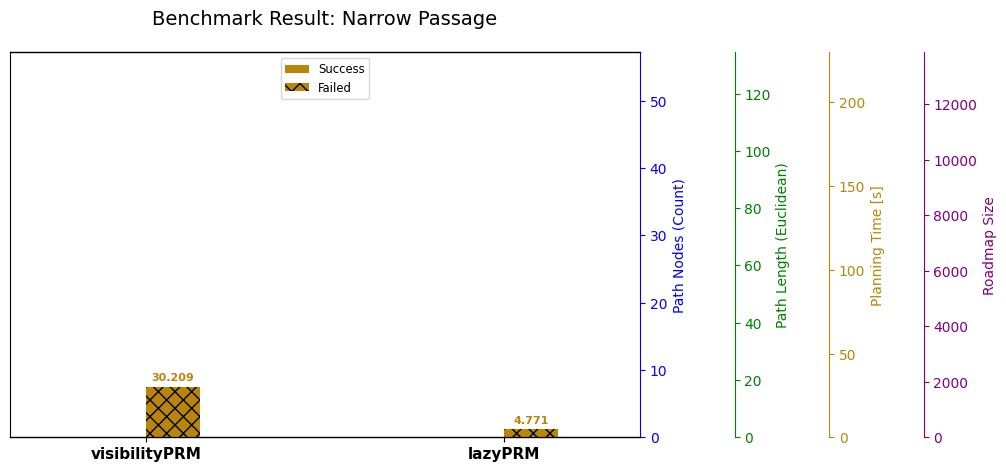

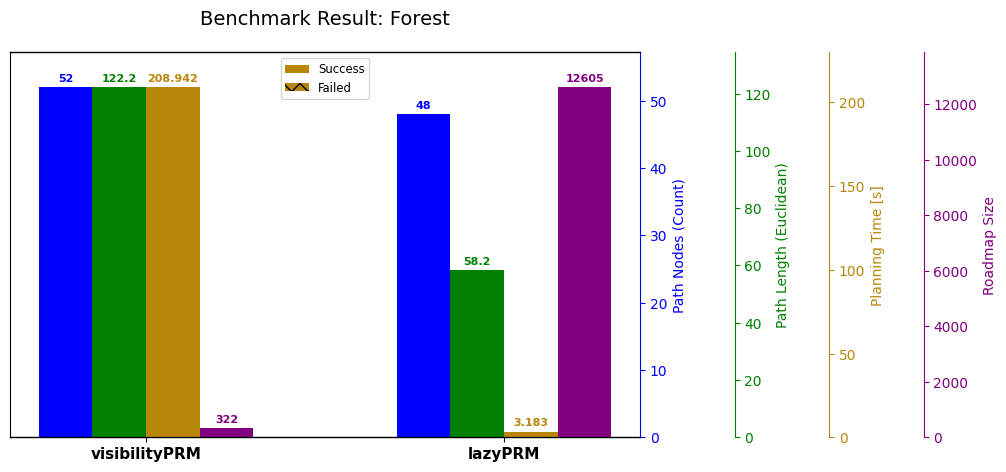

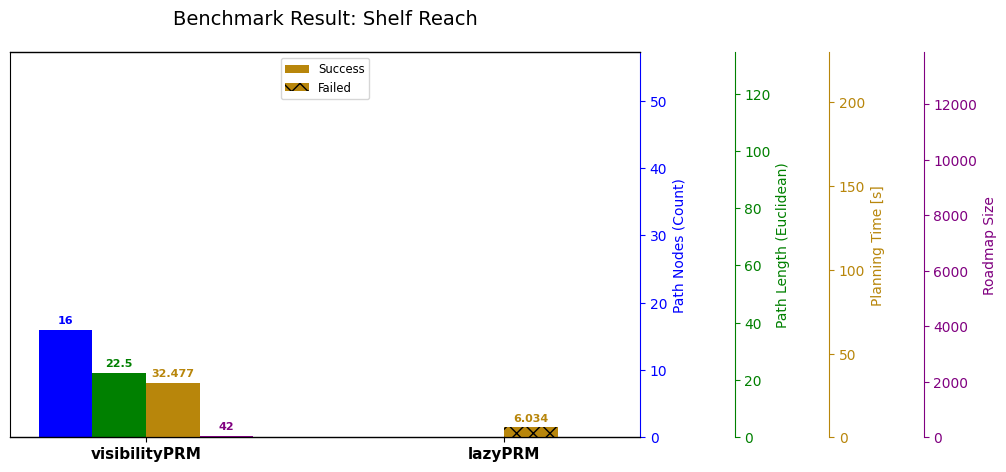

In [8]:
# Aufrufen
BenchmarkPlotter.visualize(
    resultList,
    benchList,
    save_plots=savePlots,       # Auf True setzen zum Speichern
    output_dir=folderPath2save # Ordnername
)

## Batch Evaluator

In [ ]:
# --- KONFIGURATION ---
NUMBER_OF_RUNS = 10  # Wie oft soll jeder Test wiederholt werden?

print(f"Starting Evaluation with {NUMBER_OF_RUNS} runs per scenario...")

# Batch starten
df_results = BatchEvaluator.run_experiment(plannerFactory, benchList, num_runs=NUMBER_OF_RUNS)

print("Evaluation finished.")
# Kurzer Blick auf die Daten (erste 5 Zeilen)
display(df_results.head())

# Optional: Speichern als CSV, damit die Daten nicht verloren gehen
# df_results.to_csv(f"benchmark_results_{NUMBER_OF_RUNS}runs.csv", index=False)

In [ ]:
# Visualisierung starten
BatchPlotter.visualize(
    df_results,
    save_plots=savePlots,
    output_dir=folderPath2save
)